
# Deep Learning Homework 6 (Spring 2021)

This code is provided for Deep Learning class (CS 482/682) Homework 6. For ease of implementation, we recommend working entire in Google Colaboratory.

@Copyright Cong Gao, the Johns Hopkins University, cgao11@jhu.edu. Modifications made by Hongtao Wu, Suzanna Sia, Hao Ding, and Keith Harrigian.


### Imports

In [ ]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Mounted at /content/gdrive


In [ ]:
## Standard Library
import os
import json

## External Libraries
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torch.autograd import Variable
import torch.nn.functional as functional
from torch.utils.data import Dataset, DataLoader
from skimage import io
import matplotlib.pyplot as plt

# Problem 1: Unsupervised Pre-training

### Training Hyperparameters

These are recommended hyperparameters - please feel free to use what works for you. Batch size can be changed if it does not match your memory, please state your batch step_size in your report.

In [ ]:
## Batch Size
train_batch_size = 10
validation_batch_size = 10

## Learning Rate
learning_rate = 0.001

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 200

### Data Paths

In [ ]:
# General Data Directory ##TODO: Please fill in the appropriate directory
data_dir = "gdrive/MyDrive/HW6Q1_data"

## Segmentation + Colorization Paths
segmentation_data_dir = f"{data_dir}/segmentation/"
colorization_data_dir = f"{data_dir}/colorization/"

# Mask JSON
mask_json = f"{data_dir}/mapping.json"

### Data Loaders

We have provided you with some preprocessing code for the images but you should feel free to modify the class however you please to support your training schema. In the very least, you will have to modify the dataloader to support loading of the colorization dataset.

In [ ]:
## Image Transforms
img_transform = transforms.Compose([
        transforms.ToTensor(),
])

## Image Dataloader
class ImageDataset(Dataset):
    
    """
    ImageDataset
    """
    
    def __init__(self,
                 input_dir,
                 op,
                 mask_json_path,
                 transforms=None):
        """
        ##TODO: Add support for colorization dataset
        
        Args:
            input_dir (str): Path to either colorization or segmentation directory
            op (str): One of "train", "val", or "test" signifying the desired split
            mask_json_path (str): Path to mapping.json file
            transforms (list or None): Image transformations to apply upon loading.
        """
        self.transform = transforms
        self.op = op
        self.mask_classify = mask_json_path
        #add if sentence to fit colorization task
        if len(mask_json_path)!=0:
          with open(mask_json_path, 'r') as f:
              self.mask = json.load(f)
          self.mask_num = len(self.mask)  # There are 6 categories: grey, dark grey, and black
          self.mask_value = [value for value in self.mask.values()]
          self.mask_value.sort()
          try:
              if self.op == 'train':
                  self.data_dir = os.path.join(input_dir, 'train')
              elif self.op == 'val':
                  self.data_dir = os.path.join(input_dir, 'validation')
              elif self.op == 'test':
                  self.data_dir = os.path.join(input_dir, 'test')
          except ValueError:
              print('op should be either train, val or test!')
        else:
          try:
            if self.op == 'train':
                self.data_dir = os.path.join(input_dir, 'train_cor')
            elif self.op == 'val':
                self.data_dir = os.path.join(input_dir, 'validation_cor')
          except ValueError:
              print('op should be either train, or val')
    def __len__(self):
        """
        
        """
        return len(next(os.walk(self.data_dir))[1])


    def __getitem__(self,
                    idx):
        """
        
        """
        ## Load Image and Parse Properties
        if len(self.mask_classify)==0:
          img_name = str(idx) + '_gray.jpg'
          target_name = str(idx) + '_input.jpg'
          img = io.imread(os.path.join(self.data_dir, str(idx), img_name))
          target = io.imread(os.path.join(self.data_dir, str(idx), target_name))
          if self.transform:
              img, mask = self.img_transform(img, target)
        else:
          img_name = str(idx) + '_input.jpg'
          mask_name = str(idx) + '_mask.png'
          img = io.imread(os.path.join(self.data_dir, str(idx), img_name))
          mask = io.imread(os.path.join(self.data_dir, str(idx), mask_name))
          if len(mask.shape) == 2:
              h, w  = mask.shape
          elif len(mask.shape) == 3:
              h, w, c = mask.shape
          ## Convert grey-scale label to one-hot encoding
          new_mask = np.zeros((h, w, self.mask_num))
          for idx in range(self.mask_num):
              #if the mask has 3 dimension use this code
              new_mask[:, :, idx] = mask[:,:,0] == self.mask_value[idx]
              #if the mask has 1 dimension use the code below
              #new_mask[:, :, idx] = mask == self.mask_value[idx]
          ## Transform image and mask
          if self.transform:
              img, mask = self.img_transform(img, new_mask)
          # ## Use dictionary to output
          # sample = {'img': img, 'mask': mask}
          # return sample
        return img, mask

    def img_transform(self,
                      img,
                      mask):
        """
        
        """
        ## Apply Transformations to Image and Mask
        torch.manual_seed(1) 
        img = self.transform(img)
        torch.manual_seed(1) 
        mask = self.transform(mask)
        return img, mask

## Model Architecture

Finish building the U-net architecture below.

In [ ]:
## Functions for adding the convolution layer
def add_conv_stage(dim_in,
                   dim_out,
                   kernel_size=3,
                   stride=1,
                   padding=1,
                   bias=True,
                   useBN=True):
    """
    
    """
    # Use batch normalization
    if useBN:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1)
        )
    # No batch normalization
    else:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU(),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU()
        )

## Upsampling
def upsample(ch_coarse,
             ch_fine):
    """
    
    """
    return nn.Sequential(
                    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
                    nn.ReLU())


# U-Net
class UNET(nn.Module):
    
    """
    
    """
    def __init__(self,n_classes, useBN=True):
        """
        Args:
            useBN (bool): Turn Batch Norm on or off
        """
        super(UNET, self).__init__()
        # Downgrade stages
        self.conv1 = add_conv_stage(3, 32, useBN=useBN)
        self.conv2 = add_conv_stage(32, 64, useBN=useBN)
        self.conv3 = add_conv_stage(64, 128, useBN=useBN)
        self.conv4 = add_conv_stage(128, 256, useBN=useBN)
        # Upgrade stages
        self.conv3m = add_conv_stage(256, 128, useBN=useBN)
        self.conv2m = add_conv_stage(128,  64, useBN=useBN)
        self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
        # Maxpool
        self.max_pool = nn.MaxPool2d(2)
        # Upsample layers
        self.upsample43 = upsample(256, 128)
        self.upsample32 = upsample(128,  64)
        self.upsample21 = upsample(64 ,  32)
        # weight initialization
        # You can have your own weight intialization. This is just an example.
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()
        #TODO: Design your last layer & activations
        self.last_layer = nn.Conv2d(32, 6, kernel_size=3, stride=1, padding=1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        """
        Forward pass
        """
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(self.max_pool(conv1_out))
        conv3_out = self.conv3(self.max_pool(conv2_out))
        conv4_out = self.conv4(self.max_pool(conv3_out))

        conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
        conv3m_out  = self.conv3m(conv4m_out_)

        conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
        conv2m_out  = self.conv2m(conv3m_out_)

        conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
        conv1m_out  = self.conv1m(conv2m_out_)

        #TODO: Design your last layer & activations
        conv1m_L_out  = self.last_layer(conv1m_out)
        output = self.softmax(conv1m_L_out)
        return output


### DICE Score and DICE Loss

Finish implementing the DICE score function below and then write a Dice Loss function that you can use to update your model weights.

In [ ]:
##TODO: Finish implementing the multi-class DICE score function
def dice_score_image(prediction, target, n_classes):
    '''
      computer the mean dice score for a single image

      Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does
      Args:
          prediction (tensor): predictied labels of the image
          target (tensor): ground truth of the image
          n_classes (int): number of classes
    
      Returns:
          m_dice (float): Mean dice score over classes
    '''
    ## Should test image one by one
    assert target.shape[0] == 1 #This line can not be deleted
    ## TODO: Compute Dice Score for Each Class. Compute Mean Dice Score over Classes.
    dice_classes = np.zeros(n_classes)
    smooth = 1e-6
    for cl in range(n_classes):
      pred = torch.clone(prediction)
      ind_1 = np.where(pred==cl)
      ind_2 = np.where(pred!=cl)
      pred[ind_1] = 1
      pred[ind_2] = 0

      target_t = torch.clone(target[:,cl,:,:])
      N = pred.size(0)
      pred_flat = pred.view(N, -1)
      target_flat = target_t.view(N, -1)
      TP = torch.sum(target_flat * pred_flat, dim=1)
      TP_t = torch.sum(TP).item()
     
      FP = torch.sum(pred_flat, dim=1) - TP
      FP_t = torch.sum(FP).item()

      FN = torch.sum(target_flat, dim=1) - TP
      FN_t = torch.sum(FN).item()

      #When there is no grount truth of the class in this image
      #Give 1 dice score if False Positive pixel number is 0, 
      #give 0 dice score if False Positive pixel number is not 0 (> 0).
      
      #Here I introduce smooth to solve this problem
      dice_classes[cl] = (2*TP_t+smooth)/(2*TP_t+FN_t+FP_t+smooth)
    return dice_classes.mean()



def dice_score_dataset(model, dataloader, num_classes, use_gpu=True):
    """
    Compute the mean dice score on a set of data.
    
    Note that multiclass dice score can be defined as the mean over classes of binary
    dice score. Dice score is computed per image. Mean dice score over the dataset is the dice
    score averaged across all images.
    
    Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does
     
    Args:
        model (UNET class): Your trained model
        dataloader (DataLoader): Dataset for evaluation
        num_classes (int): Number of classes
    
    Returns:
        m_dice (float): Mean dice score over the input dataset
    """
    ## Number of Batches and Cache over Dataset 
    n_batches = len(dataloader)
    scores = np.zeros(n_batches)
    ## Evaluate
    model.eval()
    idx = 0
    for data in dataloader:
        ## Format Data
        img, target = data
        if use_gpu:
            img = img.cuda()
            target = target.cuda()
        ## Make Predictions
        out = model(img)
        n_classes = out.shape[1]
        prediction = torch.argmax(out, dim = 1)
        prediction = prediction.cuda().cpu().data
        target = target.cuda().cpu().data
        scores[idx] = dice_score_image(prediction, target, n_classes)
        idx += 1
    ## Average Dice Score Over Images
    m_dice = scores.mean()
    return m_dice


## TODO: Implement DICE loss, 
#  It should conform to to how we computer the dice score.
class DICELoss(nn.Module):
    def __init__(self,):
      super(DICELoss, self).__init__()
    def forward(self, prediction, target):
      smooth = 1e-6
      #copy torch
      pred = prediction.contiguous()
      pred = pred.requires_grad_()
      target = target.contiguous()    
      target = target.requires_grad_()
      intersection = (pred * target).sum(dim=2).sum(dim=2)
      intersection = intersection.requires_grad_()
    
      # This dice_loss is a mean of an input batch
      dice_loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
      dice_loss = dice_loss.requires_grad_()
    
      return dice_loss.mean()

## Training Procedure (Segmentation)

In [ ]:
# deal with CUDA memory problem
import torch
from numba import cuda

def free_gpu_cache():                           

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

free_gpu_cache()   

Start Training...

EPOCH 1 of 200


EPOCH 2 of 200


EPOCH 3 of 200


EPOCH 4 of 200


EPOCH 5 of 200


EPOCH 6 of 200


EPOCH 7 of 200


EPOCH 8 of 200


EPOCH 9 of 200


EPOCH 10 of 200


EPOCH 11 of 200


EPOCH 12 of 200


EPOCH 13 of 200


EPOCH 14 of 200


EPOCH 15 of 200


EPOCH 16 of 200


EPOCH 17 of 200


EPOCH 18 of 200


EPOCH 19 of 200


EPOCH 20 of 200


EPOCH 21 of 200


EPOCH 22 of 200


EPOCH 23 of 200


EPOCH 24 of 200


EPOCH 25 of 200


EPOCH 26 of 200


EPOCH 27 of 200


EPOCH 28 of 200


EPOCH 29 of 200


EPOCH 30 of 200


EPOCH 31 of 200


EPOCH 32 of 200


EPOCH 33 of 200


EPOCH 34 of 200


EPOCH 35 of 200


EPOCH 36 of 200


EPOCH 37 of 200


EPOCH 38 of 200


EPOCH 39 of 200


EPOCH 40 of 200


EPOCH 41 of 200


EPOCH 42 of 200


EPOCH 43 of 200


EPOCH 44 of 200


EPOCH 45 of 200


EPOCH 46 of 200


EPOCH 47 of 200


EPOCH 48 of 200


EPOCH 49 of 200


EPOCH 50 of 200


EPOCH 51 of 200


EPOCH 52 of 200


EPOCH 53 of 200


EPOCH 54 of 200


EPOCH 55 of 200




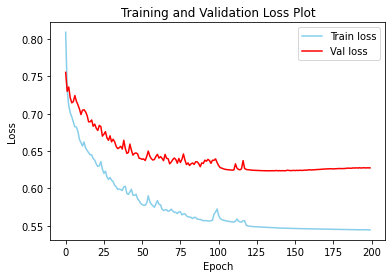

The Dice Score after training on the test dataset is： 0.6358757338833095


In [ ]:
n_classes = 6
## Initialize your unet
Diceloss = DICELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNET(n_classes).to(device)
num_epochs = 200

## Initialize Dataloaders
train_dataset=ImageDataset(input_dir=segmentation_data_dir, op="train", mask_json_path=mask_json, transforms=img_transform)
validation_dataset=ImageDataset(input_dir=segmentation_data_dir, op="val", mask_json_path=mask_json, transforms=img_transform)
test_dataset=ImageDataset(input_dir=segmentation_data_dir, op="test", mask_json_path=mask_json, transforms=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=validation_batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

print("Start Training...")
train_loss = []
val_loss = []
use_gpu = True
for epoch in range(num_epochs):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # TODO: Design your own training section
    #loss calculation and gradient update:
    loss_tol_t = 0
    for step, (batch_x, batch_y) in enumerate(train_dataloader):
      if use_gpu:
          batch_x = batch_x.to(device)
          batch_y = batch_y.to(device)
      optimizer.zero_grad()
      outputs = model(batch_x)
      #pred = (outputs > 0.5).float()
      dice_loss = Diceloss(outputs,batch_y)
      #dice_loss = dice_loss.requires_grad_()
      dice_loss.backward()

      ##performing update:
      optimizer.step()
      loss_tol_t += dice_loss.item()
    scheduler.step()
    denom = len(train_dataloader.dataset)/train_batch_size
    train_loss.append(loss_tol_t / denom)
    ########################### Validation #####################################
    # TODO: Design your own validation section
    val_loss_t = 0
    for step, (val_x, val_y) in enumerate(validation_dataloader):
      if use_gpu:
          val_x = val_x.to(device)
          val_y = val_y.to(device)
      output_val = model(val_x)
      loss_val = Diceloss(output_val,val_y)
      val_loss_t += loss_val.item()
    denom_val = len(validation_dataloader.dataset)/validation_batch_size
    val_loss.append(val_loss_t / denom_val)
## Make plot for train/val loss
plt.title('Training and Validation Loss Plot')
plt.plot(train_loss, color='skyblue', label='Train loss')
plt.plot(val_loss, color='red', label='Val loss')
plt.legend()
 
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
## The test Dice Score after training 
test_dice_score = dice_score_dataset(model, test_dataloader, n_classes)
print("The Dice Score after training on the test dataset is：",test_dice_score)

In [ ]:
#save the model
PATH = "gdrive/MyDrive/'unet1.pt'"
torch.save(model, PATH)
#load
#the_model = torch.load(PATH)

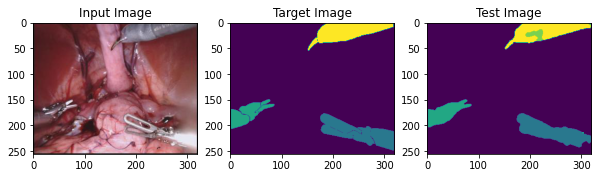

In [ ]:
PATH = "gdrive/MyDrive/'unet1.pt'"
unet1 = torch.load(PATH)

img,target = next(iter(train_dataloader))
img,target = img.to(device),target.to(device)
output = model(img).to(device)

fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 3, 1)
plt.imshow(img[1].cpu().permute(1, 2, 0))
plt.title("Input Image")

fig.add_subplot(1, 3, 2)
plt.imshow(target[1].data.cpu().numpy().argmax(axis=0))
plt.title("Target Image")

fig.add_subplot(1, 3, 3)
plt.imshow(output[1].cpu().detach().numpy().argmax(axis=0))
plt.title("Test Image")
plt.show()

### 1b try data augmentation methods
1) complete the img_transform function in ImageDataset class <br>
2) re-write image transforms : img_transform

In [ ]:
torch.manual_seed(1)
img_transform_aug = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip()
])

Generate New Dataset

In [ ]:
from torch.utils.data import ConcatDataset
train_dataset_aug=ImageDataset(input_dir=segmentation_data_dir, op="train", mask_json_path=mask_json, transforms=img_transform_aug)
combine = [train_dataset,train_dataset_aug]
train_dataset_combine = ConcatDataset(combine)
#new data loader
train_dataloader_aug = DataLoader(train_dataset_combine, batch_size=train_batch_size, shuffle=True)

Train model with dataset after augmentation

Start Training...

EPOCH 1 of 200


EPOCH 2 of 200


EPOCH 3 of 200


EPOCH 4 of 200


EPOCH 5 of 200


EPOCH 6 of 200


EPOCH 7 of 200


EPOCH 8 of 200


EPOCH 9 of 200


EPOCH 10 of 200


EPOCH 11 of 200


EPOCH 12 of 200


EPOCH 13 of 200


EPOCH 14 of 200


EPOCH 15 of 200


EPOCH 16 of 200


EPOCH 17 of 200


EPOCH 18 of 200


EPOCH 19 of 200


EPOCH 20 of 200


EPOCH 21 of 200


EPOCH 22 of 200


EPOCH 23 of 200


EPOCH 24 of 200


EPOCH 25 of 200


EPOCH 26 of 200


EPOCH 27 of 200


EPOCH 28 of 200


EPOCH 29 of 200


EPOCH 30 of 200


EPOCH 31 of 200


EPOCH 32 of 200


EPOCH 33 of 200


EPOCH 34 of 200


EPOCH 35 of 200


EPOCH 36 of 200


EPOCH 37 of 200


EPOCH 38 of 200


EPOCH 39 of 200


EPOCH 40 of 200


EPOCH 41 of 200


EPOCH 42 of 200


EPOCH 43 of 200


EPOCH 44 of 200


EPOCH 45 of 200


EPOCH 46 of 200


EPOCH 47 of 200


EPOCH 48 of 200


EPOCH 49 of 200


EPOCH 50 of 200


EPOCH 51 of 200


EPOCH 52 of 200


EPOCH 53 of 200


EPOCH 54 of 200


EPOCH 55 of 200




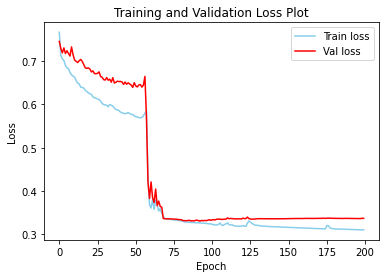

The Dice Score after training on the test dataset is： 0.7117970569937568


In [ ]:
n_classes = 6
num_epochs = 200
## Initialize your unet
Diceloss = DICELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_1 = UNET(n_classes).to(device)

## Initialize Optimizer and Learning Rate Scheduler
optimizer_aug = torch.optim.Adam(model_1.parameters(),lr=learning_rate)
scheduler_aug = torch.optim.lr_scheduler.StepLR(optimizer_aug, step_size=100, gamma=0.1)

print("Start Training...")
train_loss_aug = []
val_loss_aug = []
use_gpu = True
for epoch in range(num_epochs):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # TODO: Design your own training section
    #loss calculation and gradient update:
    loss_tol_t = 0
    for step, (batch_x, batch_y) in enumerate(train_dataloader_aug):
      if use_gpu:
          batch_x = batch_x.to(device)
          batch_y = batch_y.to(device)
      optimizer_aug.zero_grad()
      outputs = model_1(batch_x)
      dice_loss = Diceloss(outputs,batch_y)
      dice_loss.backward()

      ##performing update:
      optimizer_aug.step()
      loss_tol_t += dice_loss.item()
    scheduler_aug.step()
    denom = len(train_dataloader_aug.dataset)/train_batch_size
    train_loss_aug.append(loss_tol_t / denom)
    ########################### Validation #####################################
    # TODO: Design your own validation section
    val_loss_t = 0
    for step, (val_x, val_y) in enumerate(validation_dataloader):
      if use_gpu:
          val_x = val_x.to(device)
          val_y = val_y.to(device)
      output_val = model_1(val_x)
      loss_val = Diceloss(output_val,val_y)
      val_loss_t += loss_val.item()
    denom_val = len(validation_dataloader.dataset)/validation_batch_size
    val_loss_aug.append(val_loss_t / denom_val)
## Make plot for train/val loss
plt.title('Training and Validation Loss Plot')
plt.plot(train_loss_aug, color='skyblue', label='Train loss')
plt.plot(val_loss_aug, color='red', label='Val loss')
plt.legend()
 
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
## The test Dice Score after training 
test_dice_score = dice_score_dataset(model_1, test_dataloader, n_classes)
print("The Dice Score after training on the test dataset is：",test_dice_score)
#save model
PATH_aug = "gdrive/MyDrive/'model_aug.pt'"
torch.save(model_1, PATH_aug)

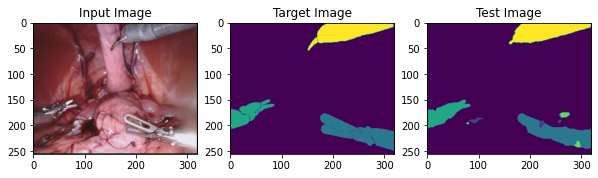

In [ ]:
img,target = next(iter(train_dataloader))
img,target = img.to(device),target.to(device)
output = model_1(img).to(device)

fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 3, 1)
plt.imshow(img[1].cpu().permute(1, 2, 0))
plt.title("Input Image")

fig.add_subplot(1, 3, 2)
plt.imshow(target[1].data.cpu().numpy().argmax(axis=0))
plt.title("Target Image")

fig.add_subplot(1, 3, 3)
plt.imshow(output[1].cpu().detach().numpy().argmax(axis=0))
plt.title("Test Image")
plt.show()

## Training Procedure: Colorization Pre-training

Complete the rest of this problem in the cells below.

### Define Dataloader

In [ ]:
train_dataset_cor=ImageDataset(input_dir=colorization_data_dir, op="train", mask_json_path="", transforms=img_transform)
train_dataloader_cor = DataLoader(train_dataset_cor, batch_size=train_batch_size, shuffle=True)

In [ ]:
img1,target1 = next(iter(train_dataloader_cor))
print(img1.shape,target1.shape)

torch.Size([10, 1, 256, 320]) torch.Size([10, 3, 256, 320])


In [ ]:
# re-define the structure of U-net
class UNET_cor(nn.Module):
    
    """
    
    """
    def __init__(self,n_classes, useBN=True):
        """
        Args:
            useBN (bool): Turn Batch Norm on or off
        """
        super(UNET_cor, self).__init__()
        # Downgrade stages
        self.conv1 = add_conv_stage(3, 32, useBN=useBN)
        self.conv2 = add_conv_stage(32, 64, useBN=useBN)
        self.conv3 = add_conv_stage(64, 128, useBN=useBN)
        self.conv4 = add_conv_stage(128, 256, useBN=useBN)
        # Upgrade stages
        self.conv3m = add_conv_stage(256, 128, useBN=useBN)
        self.conv2m = add_conv_stage(128,  64, useBN=useBN)
        self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
        # Maxpool
        self.max_pool = nn.MaxPool2d(2)
        # Upsample layers
        self.upsample43 = upsample(256, 128)
        self.upsample32 = upsample(128,  64)
        self.upsample21 = upsample(64 ,  32)
        # weight initialization
        # You can have your own weight intialization. This is just an example.
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()
        #TODO: Design your last layer & activations
        self.last_layer = nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Forward pass
        """
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(self.max_pool(conv1_out))
        conv3_out = self.conv3(self.max_pool(conv2_out))
        conv4_out = self.conv4(self.max_pool(conv3_out))

        conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
        conv3m_out  = self.conv3m(conv4m_out_)

        conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
        conv2m_out  = self.conv2m(conv3m_out_)

        conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
        conv1m_out  = self.conv1m(conv2m_out_)

        #TODO: Design your last layer & activations
        conv1m_L_out  = self.last_layer(conv1m_out)
        output = self.relu(conv1m_L_out)
        return output

Start Training...

EPOCH 1 of 50


EPOCH 2 of 50


EPOCH 3 of 50


EPOCH 4 of 50


EPOCH 5 of 50


EPOCH 6 of 50


EPOCH 7 of 50


EPOCH 8 of 50


EPOCH 9 of 50


EPOCH 10 of 50


EPOCH 11 of 50


EPOCH 12 of 50


EPOCH 13 of 50


EPOCH 14 of 50


EPOCH 15 of 50


EPOCH 16 of 50


EPOCH 17 of 50


EPOCH 18 of 50


EPOCH 19 of 50


EPOCH 20 of 50


EPOCH 21 of 50


EPOCH 22 of 50


EPOCH 23 of 50


EPOCH 24 of 50


EPOCH 25 of 50


EPOCH 26 of 50


EPOCH 27 of 50


EPOCH 28 of 50


EPOCH 29 of 50


EPOCH 30 of 50


EPOCH 31 of 50


EPOCH 32 of 50


EPOCH 33 of 50


EPOCH 34 of 50


EPOCH 35 of 50


EPOCH 36 of 50


EPOCH 37 of 50


EPOCH 38 of 50


EPOCH 39 of 50


EPOCH 40 of 50


EPOCH 41 of 50


EPOCH 42 of 50


EPOCH 43 of 50


EPOCH 44 of 50


EPOCH 45 of 50


EPOCH 46 of 50


EPOCH 47 of 50


EPOCH 48 of 50


EPOCH 49 of 50


EPOCH 50 of 50



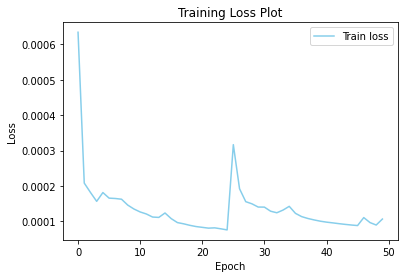

In [ ]:
## Choose an experical epoch here(based on my testing)
num_epoch_cor = 50
## Initialize your unet
MSE = nn.MSELoss()
n_classes_cor = 3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_cor = UNET_cor(n_classes_cor).to(device)

## Initialize Optimizer and Learning Rate Scheduler
optimizer_cor = torch.optim.Adam(model_cor.parameters(),lr=learning_rate)
scheduler_cor = torch.optim.lr_scheduler.StepLR(optimizer_cor, step_size=100, gamma=0.5)

print("Start Training...")
train_loss_cor = []
use_gpu = True
#num_epochs
for epoch in range(num_epoch_cor):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epoch_cor)+"\n")
    # TODO: Design your own training section
    #loss calculation and gradient update:
    loss_tol_t = 0
    for step, (batch_x, batch_y) in enumerate(train_dataloader_cor):
      if use_gpu:
          batch_x = batch_x.to(device)
          batch_y = batch_y.to(device)
      optimizer_cor.zero_grad()
      input = batch_x.repeat(1,3,1,1)
      outputs = model_cor(input)
      mse_loss = MSE(outputs,batch_y)
      mse_loss.backward()

      ##performing update:
      optimizer_cor.step()
      loss_tol_t += mse_loss.item()
    scheduler_cor.step()
    train_loss_cor.append(loss_tol_t / len(train_dataloader_cor.dataset))

## Make plot for train loss
plt.title('Training Loss Plot')
plt.plot(train_loss_cor, color='skyblue', label='Train loss')
plt.legend()
 
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10, 1, 256, 320]) torch.Size([10, 3, 256, 320])


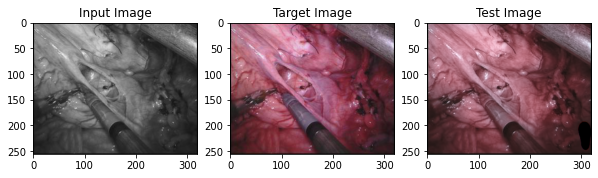

In [ ]:
#Test the effect of colorization
img,target = next(iter(train_dataloader_cor))
print(img.shape,target.shape)
img,target = img.repeat(1,3,1,1).to(device),target.to(device)
output = model_cor(img).to(device)

fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 3, 1)
plt.imshow(img[1].cpu().permute(1, 2, 0))
plt.title("Input Image")

fig.add_subplot(1, 3, 2)
#plt.imshow(target[1].data.cpu().numpy().argmax(axis=0))
plt.imshow(target[1].cpu().permute(1, 2, 0))
plt.title("Target Image")

fig.add_subplot(1, 3, 3)
plt.imshow(output[1].cpu().detach().permute(1, 2, 0))
plt.title("Test Image")
plt.show()

In [ ]:
#save the model
PATH_1 = "gdrive/MyDrive/'model_cor.pt'"
torch.save(model_cor, PATH_1)
#load
#the_model = torch.load(PATH)

###1d  transfer learning

In [ ]:
model_cor = torch.load(PATH_1)

In [ ]:
#fine-tune last layer and activation function
model_cor.last_layer = nn.Conv2d(32, 6, kernel_size=3, stride=1, padding=1)
model_cor.relu = nn.Softmax(dim=1)

Start Training...

EPOCH 1 of 200


EPOCH 2 of 200


EPOCH 3 of 200


EPOCH 4 of 200


EPOCH 5 of 200


EPOCH 6 of 200


EPOCH 7 of 200


EPOCH 8 of 200


EPOCH 9 of 200


EPOCH 10 of 200


EPOCH 11 of 200


EPOCH 12 of 200


EPOCH 13 of 200


EPOCH 14 of 200


EPOCH 15 of 200


EPOCH 16 of 200


EPOCH 17 of 200


EPOCH 18 of 200


EPOCH 19 of 200


EPOCH 20 of 200


EPOCH 21 of 200


EPOCH 22 of 200


EPOCH 23 of 200


EPOCH 24 of 200


EPOCH 25 of 200


EPOCH 26 of 200


EPOCH 27 of 200


EPOCH 28 of 200


EPOCH 29 of 200


EPOCH 30 of 200


EPOCH 31 of 200


EPOCH 32 of 200


EPOCH 33 of 200


EPOCH 34 of 200


EPOCH 35 of 200


EPOCH 36 of 200


EPOCH 37 of 200


EPOCH 38 of 200


EPOCH 39 of 200


EPOCH 40 of 200


EPOCH 41 of 200


EPOCH 42 of 200


EPOCH 43 of 200


EPOCH 44 of 200


EPOCH 45 of 200


EPOCH 46 of 200


EPOCH 47 of 200


EPOCH 48 of 200


EPOCH 49 of 200


EPOCH 50 of 200


EPOCH 51 of 200


EPOCH 52 of 200


EPOCH 53 of 200


EPOCH 54 of 200


EPOCH 55 of 200




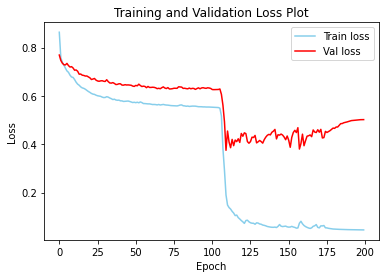

The Dice Score after training on the test dataset is： 0.8689383729676528


In [ ]:
#re-train the model
n_classes = 6
num_epochs = 200
## Initialize your unet
Diceloss = DICELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_trans = model_cor.to(device)

## Initialize Optimizer and Learning Rate Scheduler
optimizer_trans = torch.optim.Adam(model_trans.parameters(),lr=learning_rate)
scheduler_trans = torch.optim.lr_scheduler.StepLR(optimizer_trans, step_size=100, gamma=0.1)

print("Start Training...")
train_loss_tran = []
val_loss_tran = []
use_gpu = True
for epoch in range(num_epochs):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # TODO: Design your own training section
    #loss calculation and gradient update:
    loss_tol_t = 0
    for step, (batch_x, batch_y) in enumerate(train_dataloader):
      if use_gpu:
          batch_x = batch_x.to(device)
          batch_y = batch_y.to(device)
      optimizer_trans.zero_grad()
      outputs = model_trans(batch_x)
      dice_loss = Diceloss(outputs,batch_y)
      dice_loss.backward()

      ##performing update:
      optimizer_trans.step()
      loss_tol_t += dice_loss.item()
    scheduler_trans.step()
    denom = len(train_dataloader.dataset)/train_batch_size
    train_loss_tran.append(loss_tol_t / denom)
    ########################### Validation #####################################
    # TODO: Design your own validation section
    val_loss_t = 0
    for step, (val_x, val_y) in enumerate(validation_dataloader):
      if use_gpu:
          val_x = val_x.to(device)
          val_y = val_y.to(device)
      output_val = model_trans(val_x)
      loss_val = Diceloss(output_val,val_y)
      val_loss_t += loss_val.item()
    denom_val = len(validation_dataloader.dataset)/validation_batch_size
    val_loss_tran.append(val_loss_t / denom_val)
## Make plot for train/val loss
plt.title('Training and Validation Loss Plot')
plt.plot(train_loss_tran, color='skyblue', label='Train loss')
plt.plot(val_loss_tran, color='red', label='Val loss')
plt.legend()
 
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
## The test Dice Score after training 
test_dice_score = dice_score_dataset(model_trans, test_dataloader, n_classes)
print("The Dice Score after training on the test dataset is：",test_dice_score)

In [ ]:
#save the model
PATH_2 = "gdrive/MyDrive/'model_cor_trans.pt'"
torch.save(model_cor, PATH_2)

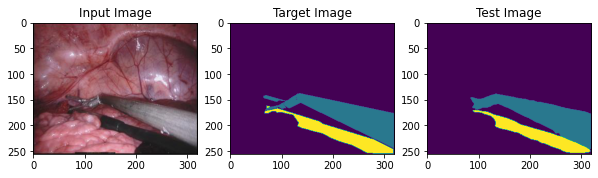

In [ ]:
img,target = next(iter(train_dataloader))
img,target = img.to(device),target.to(device)
output = model_cor(img).to(device)

fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 3, 1)
plt.imshow(img[2].cpu().permute(1, 2, 0))
plt.title("Input Image")

fig.add_subplot(1, 3, 2)
plt.imshow(target[2].data.cpu().numpy().argmax(axis=0))
plt.title("Target Image")

fig.add_subplot(1, 3, 3)
plt.imshow(output[2].cpu().detach().numpy().argmax(axis=0))
plt.title("Test Image")
plt.show()

# Problem 2: Transfer Learning

### Imports

In [ ]:
## Import VGG and FashionMNIST
from torchvision.models import vgg16
from torchvision.datasets import FashionMNIST

### Data Loading

In [ ]:
## Specify Batch Size
train_batch_size = 32
test_batch_size = 32

## Specify Image Transforms
img_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

## Download Datasets
train_data = FashionMNIST('./data', transform=img_transform, download=True, train=True)
test_data = FashionMNIST('./data', transform=img_transform, download=True, train=False)

## Initialize Dataloaders
training_dataloader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=test_batch_size, shuffle=True)


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Model Initialization and Training/Fine-tuning

Complete the rest of the assignment in the notebook below.

### 2a) VGG16 with randomly initialization

In [ ]:
#initializing network weights:
def weights_init(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
    torch.nn.init.xavier_uniform(m.weight.data)

In [ ]:
# evaluation function
def test_eval(test_dataloader,model):
  correct = 0
  total = 0
  with torch.no_grad():
    for i, (images, labels) in enumerate(test_dataloader):
        images = images.repeat(1,3,1,1)
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        #choose the item with max output as the prediction label
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
  return (100 * correct / total)
def train_eval(train_dataloader,model):
  correct = 0
  total = 0
  with torch.no_grad():
    for i, (images, labels) in enumerate(train_dataloader):
        images = images.repeat(1,3,1,1)
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
  return (100 * correct / total)

In [ ]:
# initialize model
# Randomly initialize all parameters
model_vgg = vgg16(pretrained=False)
model_vgg.classifier[-1] = nn.Linear(4096, 10)
weights_init(model_vgg)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_vgg = model_vgg.to(device)

In [ ]:
#train process
def train_vgg(model,
        optimizer,
        loss,
        lr,
        epochs,
        train_dataloader=training_dataloader,
        test_dataloader=test_dataloader,
        **kwargs):
  """
  Define the training process
  """
  model.train()
  losses = []
  for epoch in range(epochs):
    loss_vgg_t = 0
    for i, (images, labels) in enumerate(train_dataloader):
      #change the channel from 1 to 3
      input = images.repeat(1,3,1,1)
      input = input.cuda()
      labels = labels.cuda()
      
      outputs = model(input)
      #calculate metric for loss
      loss_vgg = loss(outputs, labels)
      optimizer.zero_grad()
      loss_vgg.backward()
      #performance update
      optimizer.step()
  test_vgg_acc = test_eval(test_dataloader,model)
  # the report for the model
  print("Testing Accuracy After Training:",test_vgg_acc.item())
  return model

In [ ]:
## Hyperparameters
epoch = 10
LR = 0.001
## Setting up loss function
# Use Adam optimizer
optimizer_vgg = torch.optim.Adam(model_vgg.parameters(), lr=LR)
loss_f = nn.CrossEntropyLoss()
## Run Training Loop
model_vgg_save = train_vgg(model_vgg, optimizer_vgg, loss_f, LR, epoch)
#save the model
PATH_vgg = "gdrive/MyDrive/'model_vgg_save.pt'"
torch.save(model_vgg_save, PATH_vgg)

Testing Accuracy After Training: 89.5176547964326


### 2b) VGG16 with pretrain

In [ ]:
# initialize model
model_vgg_pre = vgg16(pretrained=True)
# Freeze model weights
for param in model_vgg_pre.parameters():
    param.requires_grad = False
model_vgg_pre.classifier[-1] = nn.Linear(4096, 10)
# Randomly initialize all parameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_vgg_pre = model_vgg_pre.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
#train process
def train_vgg_pre(model,
        optimizer,
        loss,
        lr,
        epochs,
        train_dataloader=training_dataloader,
        test_dataloader=test_dataloader,
        **kwargs):
  """
  Define the training process
  """
  test_acc = []
  for epoch in range(epochs):
    loss_vgg_t = 0
    for i, (images, labels) in enumerate(train_dataloader):
      #change the channel from 1 to 3
      input = images.repeat(1,3,1,1)
      input = input.cuda()
      labels = labels.cuda()
      optimizer.zero_grad()
      outputs = model(input)
      #calculate metric for loss
      loss_vgg = loss(outputs, labels)
      loss_vgg_t += loss_vgg.item()
      loss_vgg.backward()
      #performance update
      optimizer.step()
    test_vgg_acc = test_eval(test_dataloader,model)
    test_acc.append(test_vgg_acc)
  # plot for the training loss and validation accuracy change over epochs
  iter = [i+1 for i in range(6)]
  plt.plot(iter,test_acc,'-')
  plt.xlabel('Iteration', fontsize=18)
  plt.ylabel('Testing Accuracy', fontsize=16)
  plt.show()
  # the report for the model
  print("Testing Accuracy After Training:",test_vgg_acc.item())
  return outputs

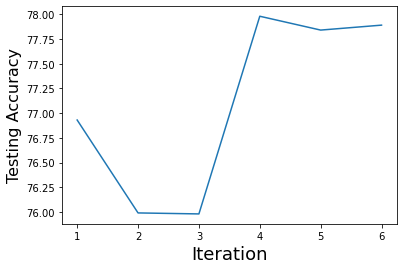

Testing Accuracy After Training: 77.88999938964844


In [ ]:
## Hyperparameters
epoch = 6
LR = 0.01
## Setting up loss function
# Use Adam optimizer
optimizer_vgg_ft = torch.optim.Adam(model_vgg_pre.parameters(), lr=LR)
loss_f = nn.CrossEntropyLoss()
## Run Training Loop
output_ft = train_vgg_pre(model_vgg_pre, optimizer_vgg_ft, loss_f, LR, epoch)